<a href="https://www.kaggle.com/code/konmue/american-options?scriptVersionId=91767672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

origin_path = "/kaggle/working"
repo_path = "/kaggle/working/american_dl"

os.chdir(origin_path)

In [3]:
!rm -rf /kaggle/working/
!git clone https://github.com/konmue/american_dl.git

rm: cannot remove '/kaggle/working/': Device or resource busy
Cloning into 'american_dl'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 58 (delta 23), reused 40 (delta 14), pack-reused 0
Unpacking objects: 100% (58/58), 76.41 KiB | 399.00 KiB/s, done.


In [4]:
os.chdir(origin_path)

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl

from tqdm import tqdm

np.set_printoptions(suppress=True)

os.chdir(repo_path)

from data.geometric_bm import geometric_bm_generator
from models.fnn import FNN, FNNParams
from deep_lsm import train_models, calculate_lower_bound
from payoffs.bermudan_max_call import bermudan_max_call

In [5]:
# Simulation params
N_SIM = 5_000_000  # Paper doesnt give this number
N_PRICING = 4_096_000
d = 5
r = 0.05
initial_value = 90
delta = 0.1
sigma = 0.2
rho = 0
K = 100
T = 3
N = 9

# NN params
fnn_params = FNNParams(
    input_dim=d + 1,
    fc_dims=[50 + d, 50 + d],
    output_dim=1,
    input_scaling=True,
    batch_norm=True,
    use_xavier_init=True,
    res_net=True,
    activation_function="relu",
    loss_fn="mse",
)

# Training params
epoch_lr_schedule = {"first": [(0.01, 1), (0.001, 1), (0.0001, 4)], "else": [(0.01, 1), (0.001, 1), (0.0001, 2)]}
batch_size = 8192

In [6]:
sim_paths = geometric_bm_generator(N_SIM, N, d, initial_value, delta, r, sigma, T)
sim_paths.shape

(5000000, 10, 5)

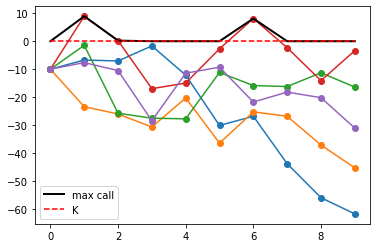

In [7]:
# plotting one sample path

max_call = np.maximum(np.amax(sim_paths[0], -1) - K, 0)

plt.plot(sim_paths[0] - K, marker='o');
plt.plot(max_call, color='k', linewidth=2, label='max call');
plt.plot(np.zeros(N+1), color='r', linestyle='dashed', label='K');
plt.legend();

In [8]:
# wrapper around payoff with fixed parameters filled in
def g(n, x):
    return bermudan_max_call(n, x, r=r, N=N, T=T, K=K)

In [9]:
models, c_0 = train_models(
    n_steps=N,
    batch_size=batch_size,
    sim_paths=sim_paths,
    epoch_lr_schedule=epoch_lr_schedule,
    fnn_params=fnn_params,
    payoff=g,
)

Training network 8


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 7


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 6


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 5


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 4


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 3


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 2


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 1


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [10]:
price_paths = geometric_bm_generator(N_PRICING, N, d, initial_value, delta, r, sigma, T)
L, sigma_L, lower_bound = calculate_lower_bound(n_steps=N, price_paths=price_paths, payoff=g, models=models, c_0=c_0)

  0%|          | 0/9 [00:05<?, ?it/s]


In [11]:
print(L, sigma_L, lower_bound)

14.196721800816107 18.668670904792275 14.214801096888793
